In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
import os
import numpy as np

file_path = './test_files/3Dblood27.11.txt'
df = pd.read_csv(file_path, header=None)
df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
df

,x,y,z,r,g,b
0,4.300000,11.197390,3.047941,0,0,0
1,4.200000,11.197390,3.047941,0,0,0
2,4.100000,11.197390,3.047941,0,0,0
3,4.000000,11.197390,3.047941,0,0,0
4,3.900000,11.197390,3.047941,0,0,0
...,...,...,...,...,...,...
1799,4.324351,10.356519,3.886832,255,0,255
1800,4.253031,10.706822,3.538061,255,0,255
1801,4.260648,10.636221,3.608462,255,0,255
1802,4.295052,11.128907,3.116422,255,0,255


In [2]:
def distance_calculator(df):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dz = df['z'].diff()

    # Calculate the Euclidean distance between consecutive rows
    distances = np.sqrt(dx**2 + dy**2 + dz**2)
    df['distance_from_last'] = distances
    return df

def remove_overlap(shape):
    # Checks for any large jumps at the end of a line and, if found, moves the last row to the top
    # This hopefully removes the jump and makes the line continuous
    # Note this seems very fragile and I probably need add a second check for large jumps at the end of the code
    if shape.iloc[-1]['distance_from_last'] > 2.:
        # Move the last row to the top
        last_row = shape.iloc[[-1]]  # Select the last row as a DataFrame
        remaining_rows = shape.iloc[:-1]  # Select all rows except the last
        shape = pd.concat([last_row, remaining_rows]).reset_index(drop=True)

    shape = distance_calculator(shape)
    return shape

def midlinejumpsplitter(shape):
    # This needs generalising to lines with more than 2 jumps
    print('Splitting line with id:', shape['line_id'].unique()[0])
    id = shape['line_id'].unique()[0]
    # Split the line at the index - at the moment uses a completely arbitrary distance of 2mm
    split_index = shape[shape['distance_from_last'] > 2.].index[0]
    shape1 = shape.iloc[:split_index]
    shape1['line_id'] = 1
    shape1['distance_from_last'].iloc[0] = np.nan
    shape2 = shape.iloc[split_index:]
    shape2['line_id'] = 2
    shape2['distance_from_last'].iloc[0] = np.nan
    return shape1, shape2

def shapesplitter(df):
    # Identify line IDs that have large jumps in the middle
    line_ids = np.sort(df['line_id'].unique())   # Sorting makes life easier later
    line_ids_new = line_ids.copy()   # A list of line IDs that we're going to update
    for line_id in line_ids:
        print(line_id)
        shape = df[df['line_id'] == line_id]
        if shape['distance_from_last'].max() > 2.:
            print(shape)
            print(shape[shape['distance_from_last'] > 2.])
            shape1, shape2 = midlinejumpsplitter(shape)
            print('Getting ride of line with id:', line_id)
            df  = df[df['line_id'] != line_id] 
            line_ids_new = line_ids_new[line_ids_new != line_id]
            line_ids_new = np.append(line_ids_new, [line_ids_new[-1]+1, line_ids_new[-1]+2])
            print('Adding lines with ids:', line_ids_new[-2], line_ids_new[-1])
            shape1['line_id'], shape2['line_id'] = line_ids_new[-2], line_ids_new[-1]
            shape = pd.concat([shape1, shape2])
            df = pd.concat([df, shape])  
    return df

# def node_finder(df):
    # Use hierarchical clustering to note common start / end points
    # Gather the first and last points of each line:

# Calculate the distance between consecutive points
df = distance_calculator(df)
# If line ID column doesn't exist, assign line IDs based on RGB values
if 'line_id' not in df.columns:
    df['line_id'] = pd.factorize(df[['r','g','b']].apply(tuple, axis=1))[0]
# Remove large jumps at the end of lines
df = df.groupby('line_id', group_keys=False).apply(remove_overlap)

# Recalculate the distance between consecutive points
df = distance_calculator(df)

# Set distance from last to NaN for the first row of each line
df.loc[df.groupby('line_id').head(1).index, 'distance_from_last'] = np.nan

# Find and split lines that have big jumps in the middle, e.g., inlet and outlet lines
df = shapesplitter(df)

# Set distance from last to NaN for the first row of each line
df.loc[df.groupby('line_id').head(1).index, 'distance_from_last'] = np.nan
df


0
            x          y         z  r  g  b  distance_from_last  line_id
0    4.300000  11.197390  3.047941  0  0  0                 NaN        0
1    4.200000  11.197390  3.047941  0  0  0                 0.1        0
2    4.100000  11.197390  3.047941  0  0  0                 0.1        0
3    4.000000  11.197390  3.047941  0  0  0                 0.1        0
4    3.900000  11.197390  3.047941  0  0  0                 0.1        0
..        ...        ...       ... .. .. ..                 ...      ...
83  22.100492  11.206475  2.978680  0  0  0                 0.1        0
84  22.200492  11.206475  2.978680  0  0  0                 0.1        0
85  22.300492  11.206475  2.978680  0  0  0                 0.1        0
86  22.400492  11.206475  2.978680  0  0  0                 0.1        0
87  22.500492  11.206475  2.978680  0  0  0                 0.1        0

[88 rows x 8 columns]
            x          y        z  r  g  b  distance_from_last  line_id
44  18.200492  11.206475  2

,x,y,z,r,g,b,distance_from_last,line_id
88,18.173898,11.206091,2.920448,0,255,0,NaN,1
89,18.130112,11.205503,2.830550,0,255,0,0.099996,1
90,18.083607,11.204930,2.742028,0,255,0,0.099996,1
91,18.034410,11.204372,2.654973,0,255,0,0.099996,1
92,17.982553,11.203830,2.569476,0,255,0,0.099996,1
...,...,...,...,...,...,...,...,...
83,22.100492,11.206475,2.978680,0,0,0,0.100000,10
84,22.200492,11.206475,2.978680,0,0,0,0.100000,10
85,22.300492,11.206475,2.978680,0,0,0,0.100000,10
86,22.400492,11.206475,2.978680,0,0,0,0.100000,10


In [48]:
start_points = df.groupby('line_id').first() # First point of each line
end_points = df.groupby('line_id').last() # Last
terminal_points = pd.concat([start_points, end_points])   # Combine the two
dist_mat = dist.pdist(terminal_points[['x', 'y', 'z']].values)   
link_mat = hier.linkage(dist_mat)
# fcluster assigns each of the particles in positions a cluster to which it belongs
cluster_idx = hier.fcluster(link_mat, t=1, criterion='distance')   # t defines the max cophonetic distance in a cluster
terminal_points['cluster'] = cluster_idx


# Calculate the mean position of each cluster
nodes = terminal_points.groupby('cluster').mean()
terminal_points
# nodes.iloc[0]
# terminal_points.loc[10]
# for n in terminal_points.index.unique():
#     shape = terminal_points[]
# Group by line_id and aggregate clusters into lists
# line_to_clusters = .groupby('line_id')['cluster'].apply(list).to_dict()

,x,y,z,r,g,b,distance_from_last,cluster
line_id,,,,,,,,
1,18.173898,11.206091,2.920448,0,255,0,0.099996,3
2,18.110164,11.386743,2.813780,0,127,0,0.099999,3
3,18.077385,11.126517,2.864335,0,255,255,0.100000,3
4,18.019722,11.206369,2.979489,255,0,0,0.100000,3
5,18.121304,10.986916,2.980895,255,255,0,0.100000,3
6,18.132802,11.296763,2.980130,255,127,0,0.100000,3
7,17.994121,11.205519,3.199386,0,0,255,0.100000,3
8,18.174472,11.022778,3.162338,255,0,255,0.099995,3
9,4.300000,11.197390,3.047941,0,0,0,0.100000,1


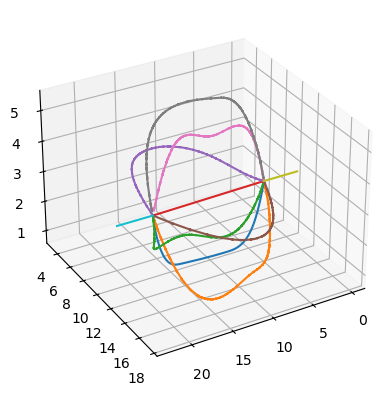

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for n in np.unique(df['line_id'].values):
    ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

# If you need a specific line plotting
# n = 2
# ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z']

# for n in np.unique(terminal_points['cluster'].values):
#     ax.scatter(terminal_points[terminal_points['cluster'] == n]['x'], terminal_points[terminal_points['cluster'] == n]['y'], terminal_points[terminal_points['cluster'] == n]['z'])

ax.view_init(elev=30, azim=60)  # Elevation of 30 degrees, azimuth of 45 degrees
plt.show()



In [ ]:


# Calculate the cluster start and end points 

In [21]:
def generate_gcode(df):
    gcode_lines = []

    # Define some starting commands if necessary
    gcode_lines.append("G21 ; Set units to millimeters")
    gcode_lines.append("G90 ; Absolute positioning")
    
    for index, row in df.iterrows():
        # Move to the start position
        gcode_lines.append(f"G0 X{row['x']} Y{row['y']} Z{row['z']} ; Move to start position")
        
        # Example of drawing or other operation
        # For simplicity, let's assume 'e' is used for setting extrusion or other properties
        gcode_lines.append(f"G1 E{row['e']} ; Set extrusion amount")
        
        # Move to another position or perform an action (for demonstration)
        gcode_lines.append(f"G1 X{row['x']+5} Y{row['y']} Z{row['z']} ; Move to another position")
    
    # Add end commands if necessary
    gcode_lines.append("M30 ; End of program")

    return "\n".join(gcode_lines)

# Generate the G-code
gcode = generate_gcode(df)

# Save to a file
with open("output.gcode", "w") as file:
    file.write(gcode)